In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input

In [2]:
# Features that will be extracted from the EM data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    # "precipitation_height": "precip",
    "sunshine_duration": "sun"
}
outlier_columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
na_columns = ["00769", "00850", "02437", "00769", "00850", "02303",	"02437", "02564", "03513", "04371"]
# Concatenate all weather parameters into one data frame
wx_dict = {}
for name, handle in wx_params.items():
    wx_dict[handle]=(pd.read_pickle("../data/weather_all_stations/cleaned/"+name+".pkl")).drop(columns=outlier_columns+na_columns)

df = pd.concat(wx_dict.values(), axis=1, ignore_index=False, verify_integrity=True, keys=wx_dict.keys())
df.head()

temp                                          \
                            00102   00161   00164   00183   00198   00232   
2020-01-01 00:00:00+00:00  279.65  272.85  274.85  277.35  271.45  274.85   
2020-01-01 01:00:00+00:00  279.35  272.85  275.35  277.55  271.05  274.35   
2020-01-01 02:00:00+00:00  279.05  271.65  275.35  277.15  270.55  274.75   
2020-01-01 03:00:00+00:00  278.95  272.55  275.25  277.45  269.75  274.65   
2020-01-01 04:00:00+00:00  278.15  273.45  275.35  277.45  268.55  274.65   

                                                           ...          sun  \
                            00282   00298   00303   00342  ...        04177   
2020-01-01 00:00:00+00:00  267.85  275.85  277.15  275.65  ...  1027.347777   
2020-01-01 01:00:00+00:00  267.25  276.65  276.55  274.95  ...  1027.347777   
2020-01-01 02:00:00+00:00  268.75  276.75  276.75  273.95  ...  1027.347777   
2020-01-01 03:00:00+00:00  268.95  276.65  276.35  272.45  ...     0.000000   
2020-01-01 04:00:00+00:00  268.85  276.55  276.25  272.05  ...     0.000000   

                                                                              \
                                 04271        04336        04393       04464   
2020-01-01 00:00:00+00:00  1040.534392  1048.137931  1021.459521  941.329432   
2020-01-01 01:00:00+00:00  1040.534392  1048.137931  1021.459521  941.329432   
2020-01-01 02:00:00+00:00  1040.534392  1048.137931  1021.459521  941.329432   
2020-01-01 03:00:00+00:00     0.000000     0.000000     0.000000    0.000000   
2020-01-01 04:00:00+00:00     0.000000     0.000000     0.000000    0.000000   

                                                                           \
                                04466       04501       04625       04642   
2020-01-01 00:00:00+00:00  938.997257  812.613654  886.156657  977.988571   
2020-01-01 01:00:00+00:00  938.997257  812.613654  886.156657  977.988571   
2020-01-01 02:00:00+00:00  938.997257  812.613654  886.156657  977.988571   
2020-01-01 03:00:00+00:00    0.000000    0.000000    0.000000    0.000000   
2020-01-01 04:00:00+00:00    0.000000    0.000000    0.000000    0.000000   

                                       
                                04745  
2020-01-01 00:00:00+00:00  839.962897  
2020-01-01 01:00:00+00:00  839.962897  
2020-01-01 02:00:00+00:00  839.962897  
2020-01-01 03:00:00+00:00    0.000000  
2020-01-01 04:00:00+00:00    0.000000  

[5 rows x 468 columns]

In [3]:
# df.clip(upper=df.mean()+5*df.std(), lower=df.mean()-5*df.std(), inplace=True, axis=1)
# df.head()

In [4]:
df.columns.levshape

(4, 117)

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]


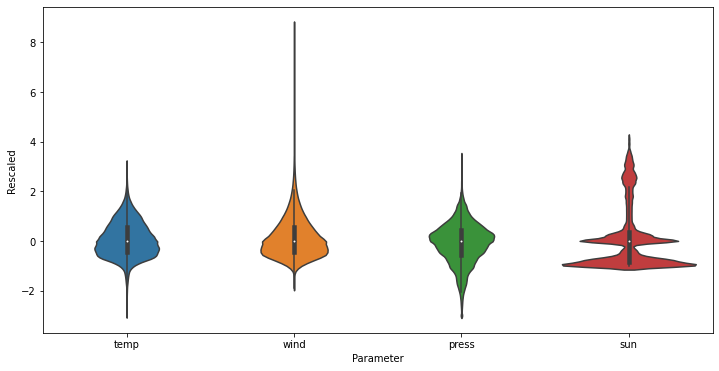

In [6]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
scaler = RobustScaler()

scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index).clip(lower=-3)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x="Parameter", y="Rescaled", data=df_train.melt(var_name='Parameter', value_name='Rescaled'))
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [7]:
df.loc[:,df.isna().any()]

2020-01-01 00:00:00+00:00
2020-01-01 01:00:00+00:00
2020-01-01 02:00:00+00:00
2020-01-01 03:00:00+00:00
2020-01-01 04:00:00+00:00
...
2021-12-31 19:00:00+00:00
2021-12-31 20:00:00+00:00
2021-12-31 21:00:00+00:00
2021-12-31 22:00:00+00:00
2021-12-31 23:00:00+00:00


In [8]:
desc=df_train["wind"].describe().transpose() # .drop(columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
desc_orig=df["sun"].describe() #

In [9]:
outliers=(df_train["sun"].max()>5)

In [10]:
print(outliers[outliers==True])

Series([], dtype: bool)


In [11]:
df.columns.levshape
# df.describe()

(4, 117)

In [12]:
X_train = df_train.to_numpy().reshape(-1, *df.columns.levshape)
X_val = df_val.to_numpy().reshape(-1, *df.columns.levshape)
X_test = df_test.to_numpy().reshape(-1, *df.columns.levshape)
input_dim=X_train.shape[1:]

# this fixes the latent space dimension, feel free to play around with
# the values for your own experiments, but leave it at 2 for the assignment
latent_dim = 20
print(input_dim)
print(X_train.shape)
print(df_train.shape)

(4, 117)
(12280, 4, 117)
(12280, 468)


In [13]:
from tensorflow.keras.backend import clear_session

clear_session()

# this is very similar to what we've done before. First, instantiate a
# "Sequential()" model in a variable called "shallow_ae". Then, add a
# "Dense()" layer to shallow_ae with latent_dim neurons, an appropriate "input_shape"
# and activation "relu". Afterwards, add another Dense layer with an appropriate
# number of neurons to be able to construct an MNIST image and "sigmoid"
# activation.
# YOUR CODE HERE
shallow_ae=Sequential()
shallow_ae.add(Dense(latent_dim, input_shape=input_dim,  activation='tanh'))
shallow_ae.add(layers.Flatten())
shallow_ae.add(Dense(X_train.shape[1]*X_train.shape[2], activation='tanh'))
shallow_ae.add(layers.Reshape(df.columns.levshape))

shallow_ae.summary()

# plot_model(shallow_ae)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4, 20)             2360      
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 468)               37908     
                                                                 
 reshape (Reshape)           (None, 4, 117)            0         
                                                                 
Total params: 40,268
Trainable params: 40,268
Non-trainable params: 0
_________________________________________________________________


In [14]:
# create an input layer with the appropriate shape
input_img = Input(shape=(*input_dim,))
input_lat = Input(shape=(latent_dim,))

# extract the first shallow_ae layer
encoder_layer = shallow_ae.layers[0]
decoder_layer = shallow_ae.layers[-1]

# make them addressable models
shallow_encoder = Model(input_img, encoder_layer(input_img))
shallow_decoder = Model(input_lat, decoder_layer(input_lat))

shallow_encoder.summary()
shallow_decoder.summary()

# #plot_model(shallow_encoder)
# plot_model(shallow_decoder)

ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [20], output_shape = [4, 117]

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 20), dtype=float32)

In [15]:
shallow_ae.compile(optimizer="adam", loss="mse")
history=shallow_ae.fit(X_train, X_train, epochs=15, batch_size=256, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/15
48/48 [==============================] - 1s 9ms/step - loss: 0.6071 - val_loss: 0.4154
Epoch 2/15
48/48 [==============================] - 0s 4ms/step - loss: 0.3965 - val_loss: 0.3665
Epoch 3/15
48/48 [==============================] - 0s 8ms/step - loss: 0.3610 - val_loss: 0.3455
Epoch 4/15
48/48 [==============================] - 0s 5ms/step - loss: 0.3383 - val_loss: 0.3290
Epoch 5/15
48/48 [==============================] - 0s 4ms/step - loss: 0.3212 - val_loss: 0.3167
Epoch 6/15
48/48 [==============================] - 0s 4ms/step - loss: 0.3086 - val_loss: 0.3069
Epoch 7/15
48/48 [==============================] - 0s 4ms/step - loss: 0.2992 - val_loss: 0.2996
Epoch 8/15
48/48 [==============================] - 0s 5ms/step - loss: 0.2920 - val_loss: 0.2937
Epoch 9/15
48/48 [==============================] - 0s 5ms/step - loss: 0.2863 - val_loss: 0.2889
Epoch 10/15
48/48 [==============================] - 0s 4ms/step - loss: 0.2817 - val_loss: 0.2849
Epoch 11/15
48/48 [

(4, 117)


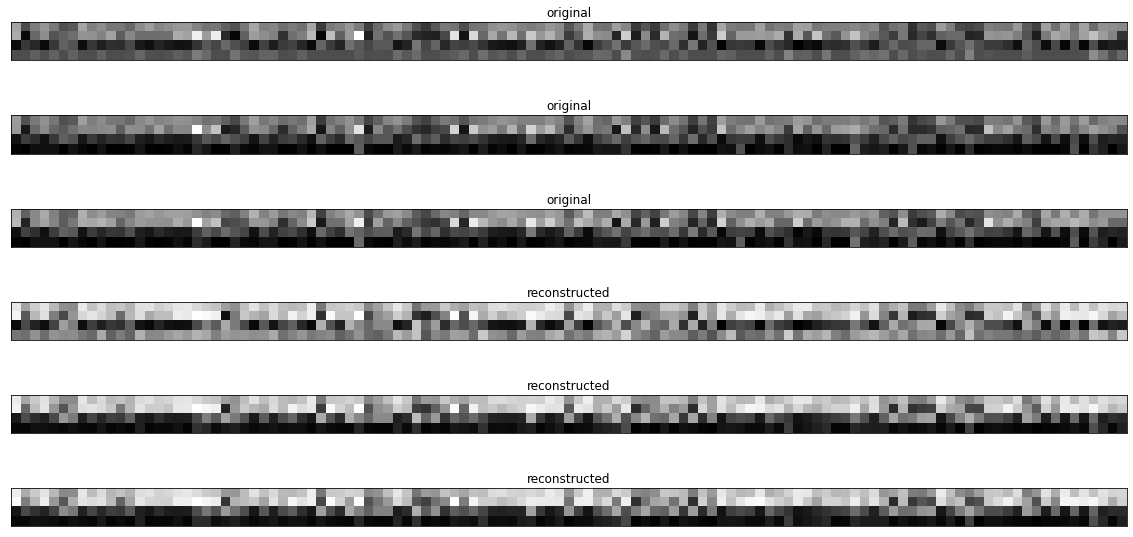

In [16]:
# encoded_imgs = shallow_encoder(df_test).numpy()
# decoded_imgs = shallow_decoder(encoded_imgs).numpy()
reconstructed_imgs = shallow_ae.predict(X_test).reshape(-1, *df.columns.levshape)
print(reconstructed_imgs[0].shape)
n = 3
offset=5
plt.figure(figsize=(20,10))

for i in range(n):
  # display original
  ax = plt.subplot(2*n, 1, i + 1)
  plt.imshow(X_test[i+offset][:][:10])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2*n, 1, i + 1 + n)
  plt.imshow(reconstructed_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


### Approach from online tutorial:

In [17]:
print(X_train.shape, X_val.shape, X_test.shape)

(12280, 4, 117) (3509, 4, 117) (1755, 4, 117)


In [18]:
latent_dim = 10

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim*2, activation='tanh'),
      layers.Dense(latent_dim, activation='tanh'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(X_train.shape[1]*X_train.shape[2]/2, activation='tanh'),
      layers.Dense(X_train.shape[1]*X_train.shape[2], activation='tanh'),
      layers.Reshape((X_train.shape[1], X_train.shape[2]))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [19]:
clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer=optimizer, loss="mae")
autoencoder.build(input_shape=X_train.shape)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (12280, 10)               9590      
                                                                 
 sequential_1 (Sequential)   (12280, 4, 117)           112554    
                                                                 
Total params: 122,144
Trainable params: 122,144
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3784 - val_loss: 0.3737
Epoch 2/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3699 - val_loss: 0.3712
Epoch 3/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3661 - val_loss: 0.3621
Epoch 4/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3635 - val_loss: 0.3589
Epoch 5/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3600 - val_loss: 0.3575
Epoch 6/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3579 - val_loss: 0.3599
Epoch 7/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3556 - val_loss: 0.3661
Epoch 8/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3559 - val_loss: 0.3612
Epoch 9/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3544 - val_loss: 0.3574
Epoch 10/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3534 - val_loss: 0.3565

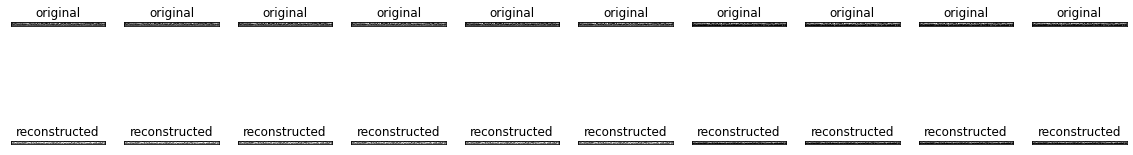

In [22]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
offset=0
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i+offset])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
